In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import make_classification
from sklearn.datasets import load_iris
from sklearn.tree import export_graphviz
import cv2
import matplotlib.pyplot as plt


FEATURE_NAMES = ['Sepal Length', 'Sepal Width', 'Petal Length', 'Petal Width']

iris = load_iris()
X = pd.DataFrame(iris.data, columns = FEATURE_NAMES)
y = iris.target

# Normal DT

In [3]:
dt = DecisionTreeClassifier(random_state=0,max_depth=5,splitter='random')
dt.fit(X,y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=0, splitter='random')

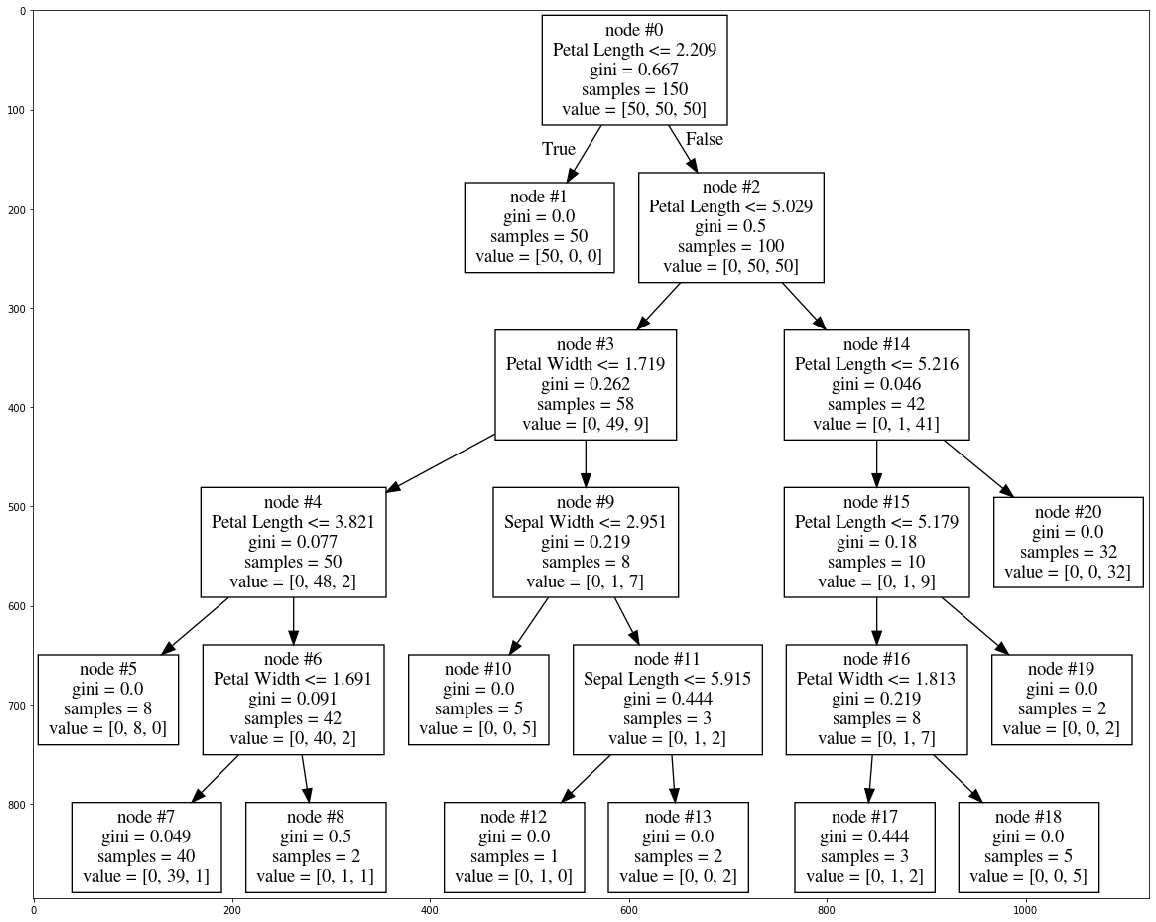

In [4]:
export_graphviz(dt, 'tree.dot', feature_names = FEATURE_NAMES,node_ids=True,proportion=False)
! dot -Tpng tree.dot -o tree.png
img = cv2.imread('tree.png')
plt.figure(figsize = (20, 20))
plt.imshow(img)

In [4]:
dt.tree_.value.shape

(21, 1, 3)

# New DT Structure

In [44]:
import pdb
class StagingDecisionTreeClassifier(DecisionTreeClassifier):
    def __init__(self,parent_sdt=None,root_sdt=None,**kwargs):
        super().__init__(**kwargs)
        self.parent_sdt = parent_sdt
        self.root_sdt = root_sdt
    
    def set_parent_sdt(self,parent_sdt):
        self.parent_sdt = parent_sdt

    def set_root_sdt(self,root_sdt):
        self.root_sdt = root_sdt
    
    def _get_crosstab_res(self,crosstab,left=True):
        try:
            if left:
                return crosstab.loc[[1]]
            return crosstab.loc[[0]]
        except:
            return None
        
    def _override_tree_node_i(self,class_cnt,node_ind):
        if node_ind >= 0:
            _class_cnt =  class_cnt
            if _class_cnt is None:
                _class_cnt = pd.DataFrame(np.zeros(self.tree_.value[node_ind,:].shape))
#             _class_cnt = pd.Series(_class_cnt)
#             print(_class_cnt)
            leaf_total = _class_cnt.values.sum()
            self.tree_.value[node_ind,:] = _class_cnt
            self.tree_.n_node_samples[node_ind] = leaf_total
            self.tree_.weighted_n_node_samples[node_ind] = leaf_total
            
    def _post_fit_setup(self,X):
        self.leafs = {leaf_id: None for leaf_id in pd.Series(self.apply(X)).unique()}
    
    def fit(self,X,y,feat_col_index=None,feature_col_threshold=None,**kwargs):
        X_ = pd.DataFrame(X.copy())
        X_.columns = [i for i in range(X.shape[1])]
        y_ = pd.Series(y.copy())
        ncols = X_.shape[1]
        if feat_col_index is not None:
            mask = np.zeros(X_.shape)
            mask[:,feat_col_index] = 1
            X_ = mask * X_
        super().fit(X_,y_,**kwargs)
        if feat_col_index is not None and feature_col_threshold is not None:
            self.tree_.threshold[0] = feature_col_threshold
            left_ind = self.tree_.children_left[0]
            right_ind = self.tree_.children_right[0]
#             pdb.set_trace()
            ct_prep_df = pd.DataFrame({'cond':(X_[feat_col_index] <= feature_col_threshold).astype('int')}).assign(y=y_)
            ct = pd.crosstab(ct_prep_df.cond,ct_prep_df.y)
            left_class_cnt = self._get_crosstab_res(ct,left=True)
            right_class_cnt = self._get_crosstab_res(ct,left=False)
            self._override_tree_node_i(left_class_cnt,left_ind)
            self._override_tree_node_i(right_class_cnt,right_ind)
#             pdb.set_trace()
            self._override_tree_node_i(pd.DataFrame(self.tree_.value[1:].sum(axis=0)),0) ###update parent
            
        self._post_fit_setup(X)    
        return self
        

sdt = StagingDecisionTreeClassifier(random_state=0,max_depth=1,splitter='best')
sdt.fit(X,y,feat_col_index=1,feature_col_threshold=3.2)


StagingDecisionTreeClassifier(parent_sdt=None, root_sdt=None)

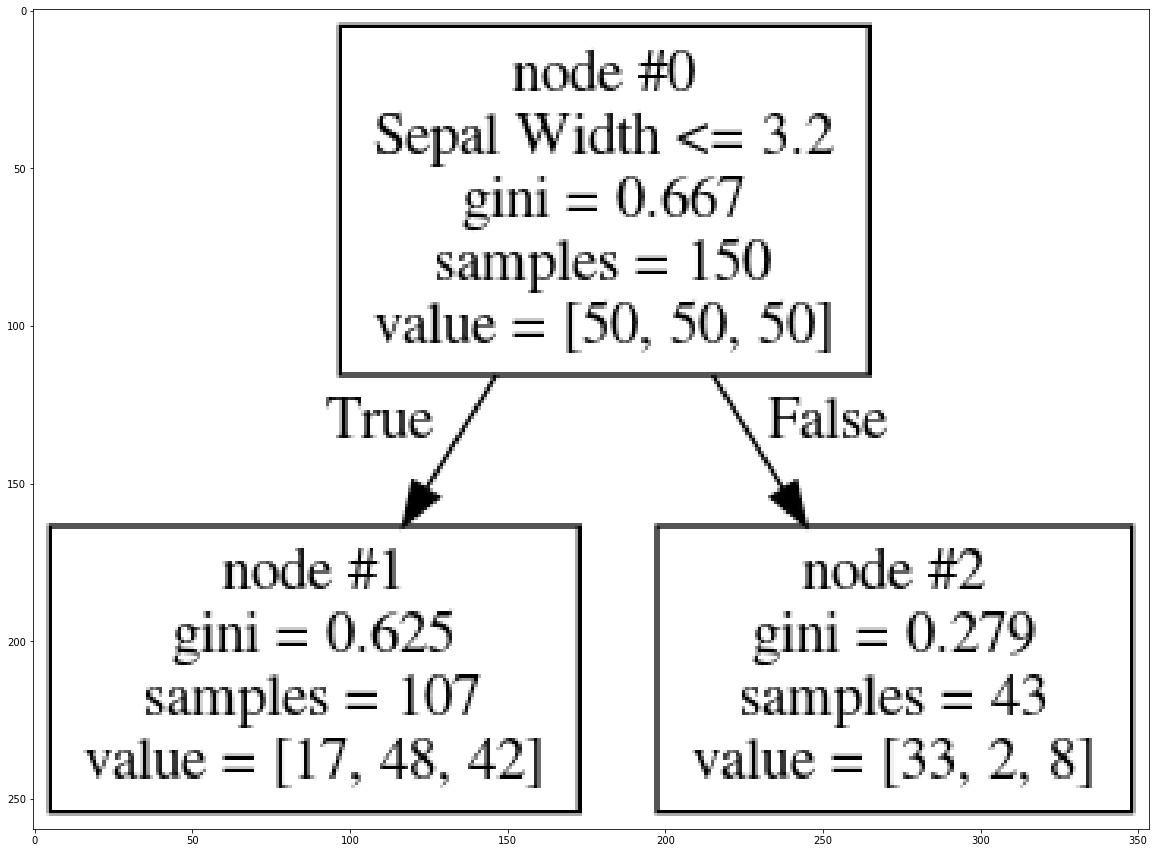

In [45]:
export_graphviz(sdt, 'tree.dot', feature_names = FEATURE_NAMES,node_ids=True,proportion=False)
! dot -Tpng tree.dot -o tree.png
img = cv2.imread('tree.png')
plt.figure(figsize = (20, 20))
plt.imshow(img)

# Convert DT to New DT

In [59]:
from copy import deepcopy

class DT2SDTConverter:
    def __init__(self,base_dt):
        self.base_dt = deepcopy(base_dt)
        
    def setup_connections(self):
        base_dt = self.base_dt
        sdts = self.sdts
        root_sdt = sdts[0]
        
        ######set parent connection
        for k,v in sdts.items():
            if k == 0:
                continue
            parent_node_id = -1
            if k in base_dt.tree_.children_left:
                parent_node_id = (base_dt.tree_.children_left == k).argmax()
            elif k in base_dt.tree_.children_right:
                parent_node_id = (base_dt.tree_.children_right == k).argmax()
            v.set_parent_sdt(sdts[parent_node_id])
            v.set_root_sdt(root_sdt)
        
        ######set children connection
        for k,v in sdts.items():
            left_child_ind = base_dt.tree_.children_left[k]
            right_child_ind = base_dt.tree_.children_right[k]
            if left_child_ind in sdts.keys(): v.leafs[1] = sdts[left_child_ind]
            if right_child_ind in sdts.keys(): v.leafs[2] = sdts[right_child_ind]

    def convert(self,X,y):
        X_ = pd.DataFrame(X.copy()).reset_index(drop=True)
        y_ = pd.Series(y.copy()).reset_index(drop=True)
        base_dt = self.base_dt
        path_df = pd.DataFrame(base_dt.decision_path(X).toarray(),index=X_.index)
        leaf_ids = pd.Series(base_dt.apply(X)).unique()
        non_leaf_ids = list(set(path_df.columns) - set(leaf_ids))
        non_leaf_path_df = path_df[non_leaf_ids]
        print(non_leaf_path_df)
        
        sdts = self.sdts = dict()
        for node_id in non_leaf_path_df.columns:
            node_thres = base_dt.tree_.threshold[node_id]
            node_feature = base_dt.tree_.feature[node_id]
            filtered_inds = (non_leaf_path_df[non_leaf_path_df[node_id] == 1]).index
            filtered_X = X_.loc[filtered_inds]
            filtered_y = y_.loc[filtered_inds]
            sdt = StagingDecisionTreeClassifier(random_state=0,max_depth=1,splitter='best')
            sdt.fit(filtered_X,filtered_y,feat_col_index=node_feature,feature_col_threshold=node_thres)
            sdts[node_id] = sdt
        self.setup_connections()
        return sdts[0]
        
        
        

sg = DT2SDTConverter(dt)
sg.convert(X,y)
# sg.sdts[0].leafs

     0   2   3   4   6   9   11  14  15  16
0     1   0   0   0   0   0   0   0   0   0
1     1   0   0   0   0   0   0   0   0   0
2     1   0   0   0   0   0   0   0   0   0
3     1   0   0   0   0   0   0   0   0   0
4     1   0   0   0   0   0   0   0   0   0
..   ..  ..  ..  ..  ..  ..  ..  ..  ..  ..
145   1   1   0   0   0   0   0   1   1   0
146   1   1   1   0   0   1   0   0   0   0
147   1   1   0   0   0   0   0   1   1   0
148   1   1   0   0   0   0   0   1   0   0
149   1   1   0   0   0   0   0   1   1   1

[150 rows x 10 columns]


StagingDecisionTreeClassifier(parent_sdt=None, root_sdt=None)

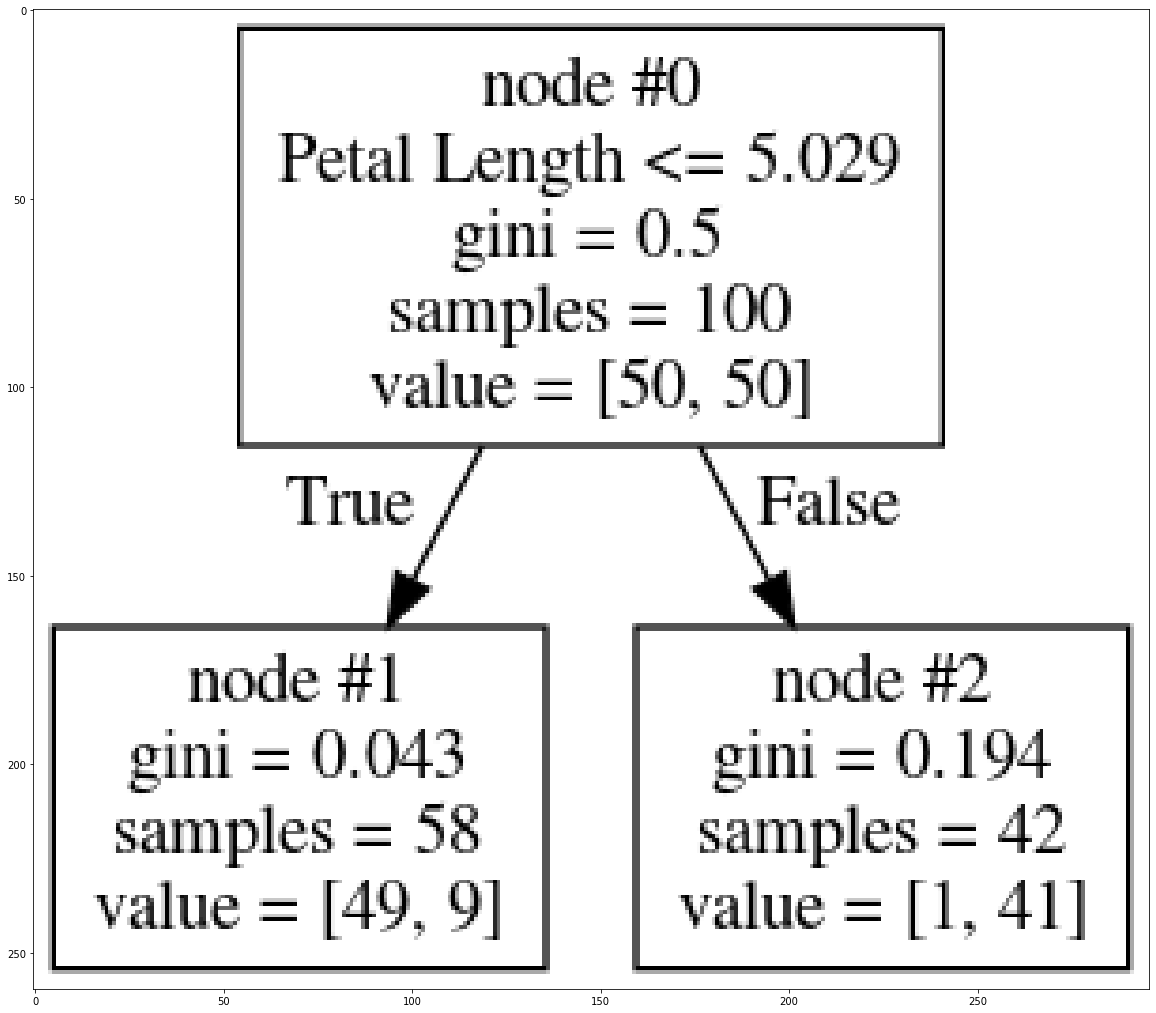

In [48]:
export_graphviz(sg.sdts[6].root_sdt.leafs[2], 'tree.dot', feature_names = FEATURE_NAMES,node_ids=True,proportion=False)
! dot -Tpng tree.dot -o tree.png
img = cv2.imread('tree.png')
plt.figure(figsize = (20, 20))
plt.imshow(img)

# Convert New DT to DT

In [ ]:


class SDT2DTConverter:
    def __init__(self,root_sdt):
        self.root_sdt = deepcopy(root_sdt)
    def convert(self,X,y):
        new_sdt = StagingDecisionTreeClassifier(random_state=0)

# Playground 2

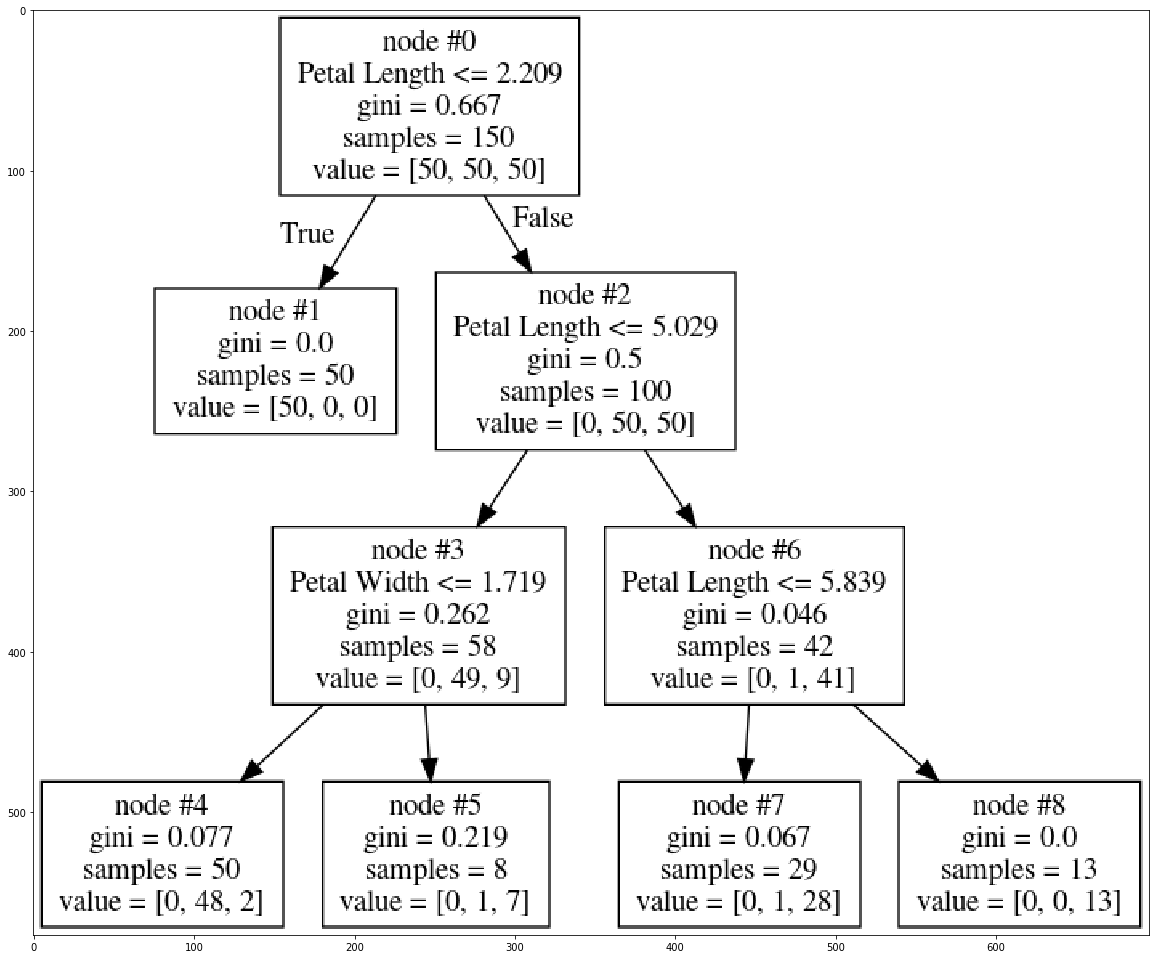

In [57]:
dt3 = DecisionTreeClassifier(random_state=0,max_depth=3,splitter='random')
dt3.fit(X,y)

export_graphviz(dt3, 'tree.dot', feature_names = FEATURE_NAMES,node_ids=True,proportion=False)
! dot -Tpng tree.dot -o tree.png
img = cv2.imread('tree.png')
plt.figure(figsize = (20, 20))
plt.imshow(img)

In [89]:
# dt3.tree_.value#[0] = np.append(dt3.tree_.value[0],1)
# dt3.tree_.children_left = np.append(dt3.tree_.children_left,1)

import sklearn.tree as tree
tree._tree.Tree

sklearn.tree._tree.Tree

# Playground

In [347]:
node_id = 0

node_thres = dt.tree_.threshold[node_id]
node_feature = dt.tree_.feature[node_id]
node_thres,node_feature

(2.2093678375653827, 2)

In [117]:
dt.tree_.feature

array([ 2, -2,  2,  3,  2, -2,  3, -2, -2,  1, -2,  0, -2, -2,  2,  2,  3,
       -2, -2, -2, -2])

In [474]:
shit = pd.DataFrame(X_)
shit['y'] = y_
# shit[shit[2] <= 0].y.value_counts().sort_index()
# shit[shit[2] > 0].y.value_counts().sort_index()


shit['hit'] = (shit[2] <= 1)
pd.crosstab(shit.hit,shit.y).sum(axis=0)

y
0    50
1    50
2    50
dtype: int64

In [460]:
dt2 = DecisionTreeClassifier(random_state=0,max_depth=1)
X_ = X.copy()
y_ = y.copy()


#####prepare X_
for i in range(X_.shape[1]):
    if i != node_feature:
        X_[:,i] = 0
        
dt2.fit(X_,y_)
dt2.tree_.threshold[0] = 1

In [332]:
dt2.tree_.children_left

array([ 1, -1, -1])

In [465]:
dt2.tree_.value[1:].sum(axis=0)

array([[50., 50., 50.]])

In [343]:
dt2.tree_.value[left_ind,:] = np.zeros(dt2.tree_.value[left_ind,:].shape)


In [341]:
left_ind = dt2.tree_.children_left[0]
right_ind = dt2.tree_.children_right[0]

shit2 = pd.crosstab((X_[:,node_feature] <= 0).astype('int') , y_)
print(shit2)
new_left_class_cnt = shit2.loc[[1]]
new_right_class_cnt = shit2.loc[[0]]

new_left_total = new_left_class_cnt.values.sum()
new_right_total = new_right_class_cnt.values.sum()

left_ind = dt2.tree_.children_left[0]
right_ind = dt2.tree_.children_right[0]

dt2.tree_.value[left_ind,:] = new_left_class_cnt
dt2.tree_.value[right_ind,:] = new_right_class_cnt

dt2.tree_.n_node_samples[left_ind] = new_left_total
dt2.tree_.n_node_samples[right_ind] = new_right_total

dt2.tree_.weighted_n_node_samples[left_ind] = new_left_total
dt2.tree_.weighted_n_node_samples[right_ind] = new_right_total

col_0   0   1   2
row_0            
0      50  50  50


KeyError: "None of [Int64Index([1], dtype='int64', name='row_0')] are in the [index]"

In [329]:
new_left_class_cnt.values.sum()

1

In [321]:
shit2.loc[[0]].values

array([[50, 50, 50]])

In [294]:
dir(dt2.tree_)

['__class__',
 '__delattr__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__ne__',
 '__new__',
 '__pyx_vtable__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 'apply',
 'capacity',
 'children_left',
 'children_right',
 'compute_feature_importances',
 'compute_partial_dependence',
 'decision_path',
 'feature',
 'impurity',
 'max_depth',
 'max_n_classes',
 'n_classes',
 'n_features',
 'n_leaves',
 'n_node_samples',
 'n_outputs',
 'node_count',
 'predict',
 'threshold',
 'value',
 'weighted_n_node_samples']

In [308]:
pd.DataFrame(dt2.decision_path(X_).toarray()).groupby([0,1,2]).size()

pd.Series(dt2.apply(X_)).value_counts()

2    149
1      1
dtype: int64

In [112]:
# shit['y_pred'] = dt2.predict(X_)
# shit[shit[2] <= 5.1].y_pred.value_counts()




0    116
Name: y_pred, dtype: int64

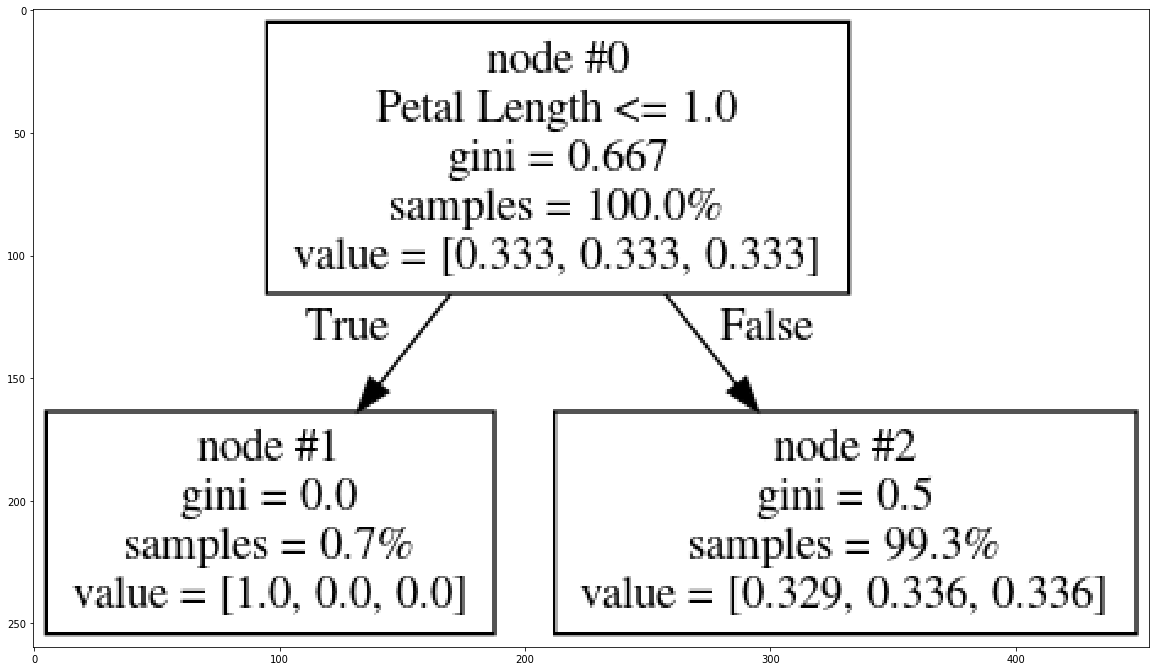

In [331]:
export_graphviz(dt2, 'tree.dot', feature_names = FEATURE_NAMES,node_ids=True,proportion=True)
! dot -Tpng tree.dot -o tree.png
img = cv2.imread('tree.png')
plt.figure(figsize = (20, 20))
plt.imshow(img)

In [292]:
1/50

0.02

In [31]:
iris = load_iris()
X = iris.data
y = iris.target
# X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

clf = DecisionTreeClassifier(max_leaf_nodes=3, random_state=0)
clf.fit(X, y)

clf.tree_